# 1. Setup

In [1]:
import shutil

import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.optimize import curve_fit

from utils import *

# 2. Prepare data

## 2.1. Accessibility by mode, purpose & SES

Copy the processed data of BG geometries, opportunities distribution, and interzonal deterrence data from the accessibility project folder.

In [2]:
inroot = Path('../../access/data')
outroot = mkdir('../data/access')

In [36]:
msa = 'indianapolis'

### 2.1.1. Block groups

In [37]:
def get_msa_zones(msa, exc_counties=[], overwrite=False):
    outpath = outroot / f'zones/{msa}.parquet'
    if (df := file_check(outpath, overwrite)) is not None: return df
    df = gpd.read_parquet(inroot / 'zones/msa_2020.parquet', filters=[
        ('region', '==', msa), ('scale', '==', 'bg')])
    df['cnty_id'] = df.geoid.str[:5]
    cnty = pd.read_parquet(inroot / 'zones/us/county_2020.parquet', columns=[
        'geoid', 'name']).rename(columns=D(geoid='cnty_id', name='county'))
    df = df.merge(cnty, on='cnty_id')
    df = df[~df.county.isin(exc_counties)]
    popu = pd.read_parquet(inroot / 'ses/acs_2021.parquet', filters=[
        ('scale', '==', 'bg')], columns=['geoid', 'popu'])
    df = df.merge(popu, 'left', on='geoid').to_crs(CRS_M)
    df['pop_density'] = df['popu'].fillna(0) / (df['aland'] * SQM2SQMI)
    df = df[['geoid', 'county', 'popu', 'pop_density', 'geometry']]
    df.to_parquet(mkfile(outpath))
    return df

zones = get_msa_zones(msa, exc_counties=['Brown', 'Tipton'], overwrite=1).disp()

1,400 rows x 5 cols; Memory: 0.2 MiB; <Projected CRS: EPSG:3857>


geoid    county       popu pop_density  \
       <object>  <object>  <float64>   <float64>   
0  180118101001     Boone     1347.0     36.7519   

                                            geometry  
                                          <geometry>  
0  POLYGON ((-9638231.869211 4878118.620342, -963...

### SES

In [55]:
def get_ses(msa, ses_cols=('p_senior', 'p_poc', 'p_noveh', 'm_hhperveh',
                           'p_renter', 'p_unemploy', 'm_income', 'p_pov')):
    df = pd.read_parquet(outroot / 'acs_2021.parquet')
    df = get_msa_zones(msa)[['geoid', 'county', 'geometry']].merge(df)
    df['sedi'] = df[list(ses_cols)].apply(lambda x: x.fillna(0).rank(pct=1)).mean(1)
    df = df[['geoid', 'sedi', 'county', 'geometry']]
    return df

x = get_ses(msa); x

geoid      sedi  county  \
0     180118101001  0.354779   Boone   
1     180118101002  0.199516   Boone   
2     180118101003  0.414858   Boone   
3     180118102001  0.302367   Boone   
4     180118102002  0.323709   Boone   
...            ...       ...     ...   
1389  181457108004  0.294207  Shelby   
1390  181457108005  0.251345  Shelby   
1391  181457109001  0.350072  Shelby   
1392  181457109002  0.445929  Shelby   
1393  181457109003  0.433555  Shelby   

                                               geometry  
0     POLYGON ((-9638231.869 4878118.620, -9638230.7...  
1     POLYGON ((-9627005.187 4889718.524, -9626995.2...  
2     POLYGON ((-9614225.264 4888652.448, -9614223.5...  
3     POLYGON ((-9642435.293 4880363.876, -9642434.9...  
4     POLYGON ((-9650925.965 4887081.875, -9650931.6...  
...                                                 ...  
1389  POLYGON ((-9556767.932 4792051.817, -9556384.6...  
1390  POLYGON ((-9568071.202 4788018.387, -9568067.0...  
1391  POLYGON ((-9568268.682 4776757.364, -9568262.4...  
1392  POLYGON ((-9546740.717 4777353.358, -9546716.6...  
1393  POLYGON ((-9558052.114 4773164.286, -9557904.0...  

[1394 rows x 4 columns]

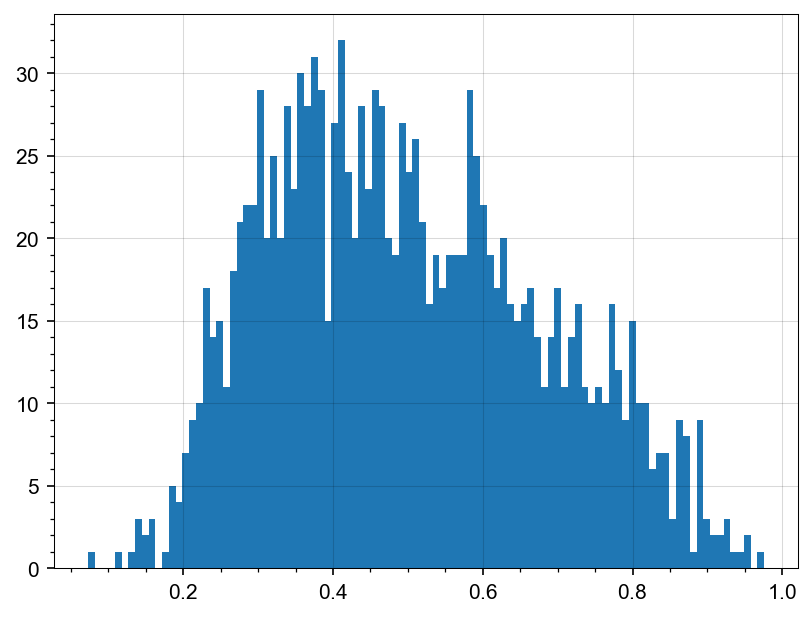

In [58]:
x.sedi.hist(bins=100, ax=pplot(size=9));

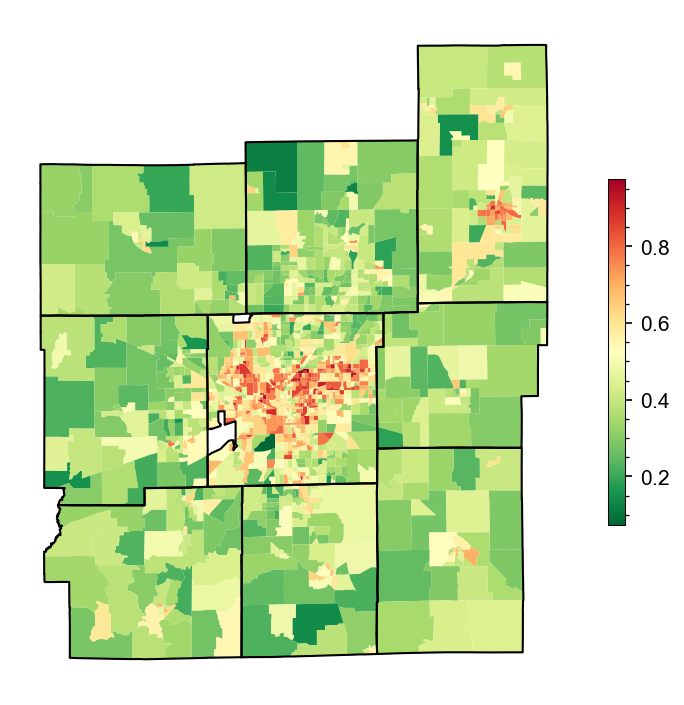

In [56]:
ax = pplot(size=(6, 6), axoff=1)
x.plot(ax=ax, column='sedi', cmap='RdYlGn_r', legend=True, legend_kwds=D(shrink=0.5))
x.dissolve('county').plot(ax=ax, fc='none', ec='k');

In [40]:
x.columns

Index(['scale', 'geoid', 'popu', 'pop_density', 'p_minor', 'p_poc', 'p_lowedu',
       'm_income', 'p_pov', 'p_pov150', 'p_pov200', 'p_snap', 'p_unemploy',
       'p_noinsur', 'p_disabled', 'p_lowenglish', 'p_snglparent', 'p_crowded',
       'p_renter', 'p_mobilehome', 'p_noveh', 'm_hhperveh', 'p_nowfh',
       'p_transit', 'p_walkbike'],
      dtype='object')

### 2.1.2. Opportunities

In [4]:
def get_opportunities(msa, overwrite=False):
    outpath = outroot / f'opportunities/{msa}.parquet'
    if (df := file_check(outpath, overwrite)) is not None: return df
    df = pd.read_parquet(inroot / 'opport/opportunities.parquet')
    df['purpose'] = df.kind.map(D(total='Work', overall='Non-work'))
    df = df[['geoid', 'purpose', 'opport']].dropna()
    df = df.merge(get_msa_zones(msa)['geoid'])
    df.to_parquet(mkfile(outpath))
    return df

opp = get_opportunities('indianapolis', overwrite=1).disp()

2,724 rows x 3 cols; Memory: 0.4 MiB


geoid   purpose   opport
       <object>  <object>  <int32>
0  180118101001      Work      183

### 2.1.3. Distances

In [5]:
# for msa, mode in it.product(['indianapolis'], ['drive', 'walk', 'bike']):
#     path = inroot / f'od_cost/osrm/msa/{msa}/bg_{mode}_2020.parquet'
#     shutil.copy(path, mkfile(outroot / f'dist/{msa}_{mode}.parquet'))

### 2.1.4. Impedance function params

In [6]:
def get_imped_params(func=lambda x, a, b: np.exp(-a * x ** b)):
    trips = pd.read_parquet(DATA / 'trips2.parquet')
    def get_params(df):
        y = df['Time'].clip(0, 120)
        y, x = np.histogram(y, bins=np.arange(0, 121))
        y = (1 - (y / y.sum()).cumsum()).clip(0)
        return D(zip(['β1', 'β2'], curve_fit(func, x[1:], y)[0]))
    res = [D(Mode='Overall', Purpose='Overall') | get_params(trips)]
    for (mode, purpose), df in trips.groupby(['Mode', 'Purpose']):
        if mode == 'Transit': continue
        res.append(D(Mode=mode, Purpose=purpose) | get_params(df))
    res = Pdf(res)
    return res

params = get_imped_params().disp(None)

7 rows x 4 cols; Memory: 0.0 MiB


Mode   Purpose         β1         β2
   <object>  <object>  <float64>  <float64>
0   Overall   Overall   0.022688   1.282219
1     Drive      Work   0.007127   1.501453
2     Drive  Non-work   0.020097   1.361629
3      Walk      Work   0.053588   1.085346
4      Walk  Non-work   0.058269   1.007449
5      Bike      Work   0.007653   1.591413
6      Bike  Non-work    0.02808   1.145222

## 2.2. Compute accessibility

### 2.2.1. At BG level

In [35]:
# def get_access_bg(msa, tmax=90, params=params, outroot=outroot, overwrite=False):
#     outpath = outroot / f'comparison_time/{msa}.parquet'
#     if outpath.exists() and not overwrite:
#         return pd.read_parquet(outpath)
#     zones = get_msa_zones(msa)[['geoid', 'popu']]
#     opp = get_opportunities(msa)
#     res = []
#     overall, params = params.iloc[0], params.iloc[1:]
#     for mode in tqdm(params.Mode.unique()):
#         fpath = outroot / f'dist/{msa}_{mode.lower()}.parquet'
#         dist = pd.read_parquet(fpath).rename(columns=D(
#             src_geoid='geoid', trg_geoid='trg', duration='time'))
#         dist.time /= 60 # s to min
#         for purpose in params.Purpose.unique():
#             df = opp.query(f'purpose=="{purpose}"')
#             df = dist.merge(df.rename(columns=D(geoid='trg')))
#             df = df[df.time <= tmax][['geoid', 'time', 'opport']]
#             row = params.query(f'Mode=="{mode}" & Purpose=="{purpose}"').iloc[0]
#             df['general'] = df.opport * np.exp(-overall.β1 * (df.time ** overall.β2))
#             df['case'] = df.opport * np.exp(-row.β1 * (df.time ** row.β2))
#             df = df.merge(zones[['geoid', 'popu']], on='geoid')
#             df = (df.groupby('geoid')[['general', 'case']]
#                   .sum().astype(np.float32).reset_index())
#             df = df.merge(zones[['geoid', 'popu']], on='geoid')
#             df['pct_diff'] = (df.case / (df.general + 1e-6) - 1) * 100
#             res.append(df.assign(mode=mode, purpose=purpose))
#     res = pd.concat(res).astype(D(geoid=CAT, mode=CAT, purpose=CAT))
#     res.to_parquet(mkfile(outpath))
#     return res

# xs_bg = get_access_bg('indianapolis', overwrite=1).disp() # t=0:16
# # x = get_access_bg('indianapolis', overwrite=1); x

In [28]:
def get_access_bg(msa, tmax=90, params=params, outroot=outroot, overwrite=False):
    outpath = outroot / f'comparison_time/{msa}.parquet'
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    zones = get_msa_zones(msa)[['geoid', 'popu']]
    opp = get_opportunities(msa)
    res = []
    overall, params = params.iloc[0], params.iloc[1:]
    for mode in tqdm(params.Mode.unique()):
        fpath = outroot / f'dist/{msa}_{mode.lower()}.parquet'
        dist = pd.read_parquet(fpath).rename(columns=D(
            src_geoid='geoid', trg_geoid='trg', duration='time'))
        dist.time /= 60 # s to min
        for purpose in params.Purpose.unique():
            df = opp.query(f'purpose=="{purpose}"')
            df = dist.merge(df.rename(columns=D(geoid='trg')))
            df = df[df.time <= tmax][['geoid', 'time', 'opport']]
            row = params.query(f'Mode=="{mode}" & Purpose=="{purpose}"').iloc[0]
            df['general'] = df.opport * np.exp(-overall.β1 * (df.time ** overall.β2))
            df['case'] = df.opport * np.exp(-row.β1 * (df.time ** row.β2))
            df = df.merge(zones[['geoid', 'popu']], on='geoid')
            df = (df.groupby('geoid')[['general', 'case']]
                  .sum().astype(np.float32).reset_index())
            df = df.merge(zones[['geoid', 'popu']], on='geoid')
            df['pct_diff'] = (df.case / (df.general + 1e-6) - 1) * 100
            res.append(df.assign(mode=mode, purpose=purpose))
    res = pd.concat(res).astype(D(geoid=CAT, mode=CAT, purpose=CAT))
    res.to_parquet(mkfile(outpath))
    return res

xs_bg = get_access_bg('indianapolis', overwrite=1).disp() # t=0:16
# x = get_access_bg('indianapolis', overwrite=1); x

  0%|          | 0/3 [00:00<?, ?it/s]

8,400 rows x 7 cols; Memory: 0.4 MiB


geoid       general           case       popu   pct_diff  \
     <category>     <float32>      <float32>  <float64>  <float32>   
0  180118101001  69513.695312  137205.171875     1347.0  97.378624   

         mode     purpose  
   <category>  <category>  
0       Drive        Work

In [8]:
xs_bg.groupby(['mode', 'purpose'])[['case', 'general']].mean()

case        general
mode  purpose                               
Bike  Non-work     962.955811     623.383545
      Work       25320.152344   24607.529297
Drive Non-work    4649.307617    5476.975098
      Work      317723.531250  205323.890625
Walk  Non-work      94.928894      87.004189
      Work        2607.316406    3299.604004

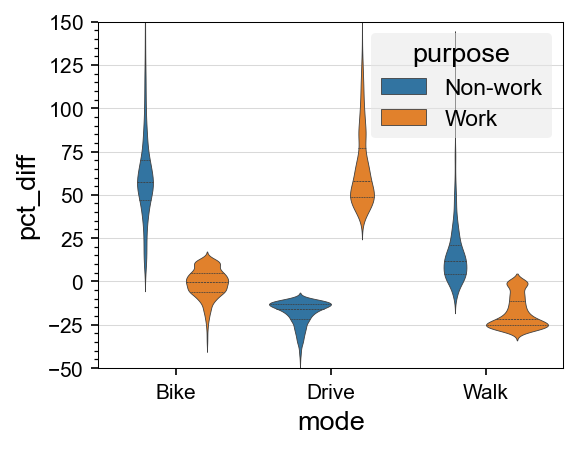

In [9]:
ax = pplot(size=(4, 3), dpi=150, ylim=(-50, 150), xminor=0)
sns.violinplot(xs_bg, ax=ax, x='mode', y='pct_diff', hue='purpose', linewidth=0.4, inner='quart');

In [10]:
# def fig_access_comparison(mode, purpose, xs_bg=xs_bg, zones=zones, dpi=150):
#     xs = zones.merge(xs_bg.query(f'mode=="{mode}" & purpose=="{purpose}"'))
#     ax = pplot(size=(6, 4), xlab='Pop density', ylab='% diff')
#     ax.scatter(xs.pop_density, xs.case, s=xs.popu / 1000, color='r')
#     return xs

# x = fig_access_comparison('Drive', 'Work'); x

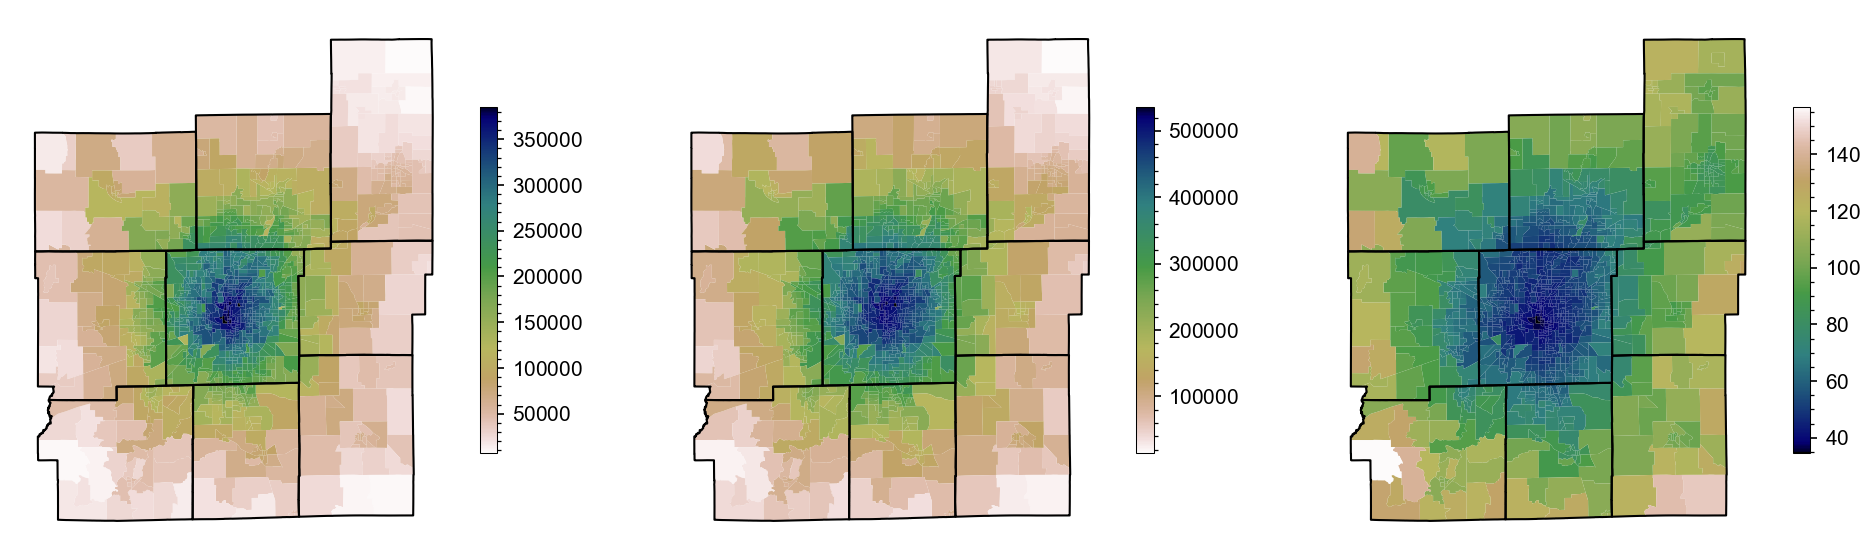

In [34]:
def fig_access_comparison2(mode, purpose, xs_bg=xs_bg, zones=zones,
                          pctile=False, dpi=150):
    xs = zones.merge(xs_bg.query(f'mode=="{mode}" & purpose=="{purpose}"'), 'left')
    if pctile:
        for col in ['case', 'general', 'pct_diff']:
            xs[col] = xs[col].rank(pct=True) * 100
    _, axes = plt.subplots(1, 3, figsize=(16, 6), dpi=dpi)
    for i, (col, cmap) in enumerate([('general', 'gist_earth_r'),
                                     ('case', 'gist_earth_r'),
                                     ('pct_diff', 'gist_earth')]):
        ax = pplot(axes[i], axoff=1)
        xs.plot(ax=ax, column=col, cmap=cmap, legend=True, legend_kwds=D(shrink=0.5))
        xs.dissolve('county').plot(ax=ax, fc='none', ec='k', lw=1)
        # ctx.add_basemap(ax=ax, crs=CRS_M, source=ctx.providers.CartoDB.Positron)
        # ax.add_artist(ScaleBar(0.2))

x = fig_access_comparison2('Drive', 'Work', pctile=0); x

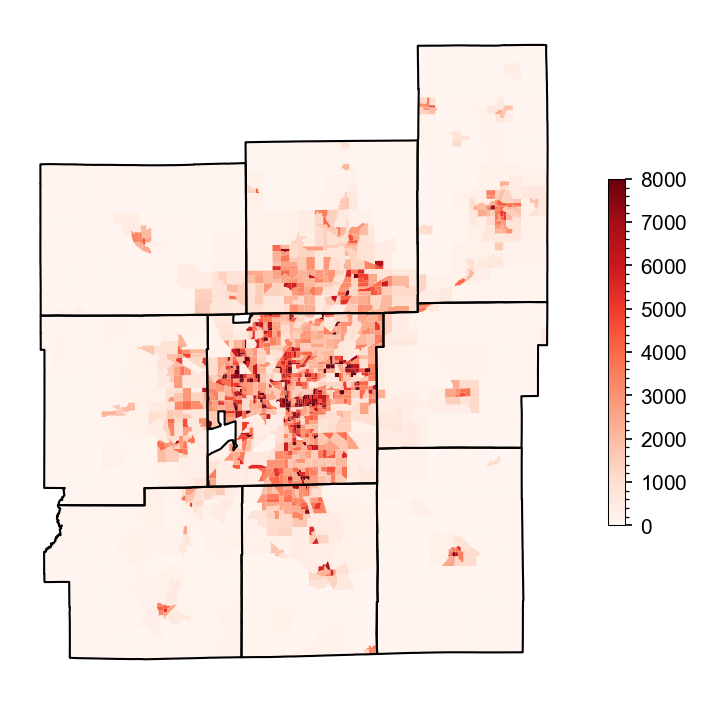

In [20]:
ax = pplot(size=(6, 6), axoff=1)
zones.plot(ax=ax, column='pop_density', cmap='Reds', vmin=0, vmax=8e3, legend=1, legend_kwds=D(shrink=0.5))
zones.dissolve('county').plot(ax=ax, fc='none', ec='k', lw=1);

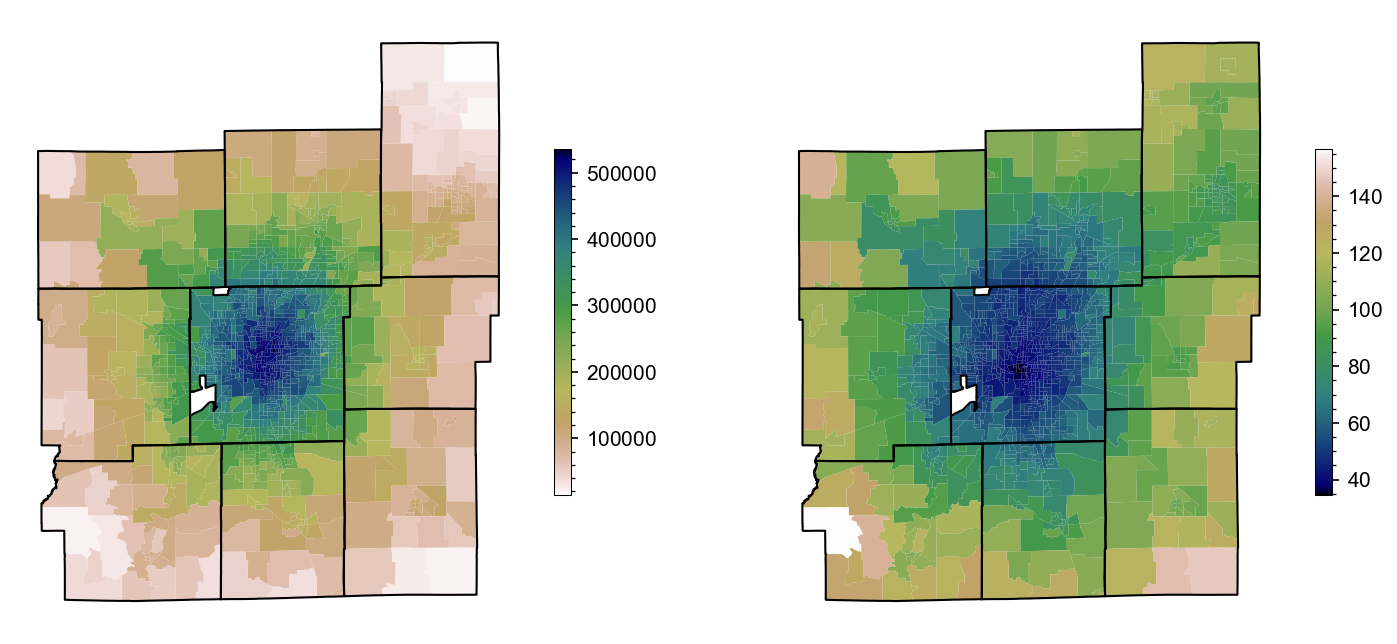

In [12]:
def fig_access_comparison(mode, purpose, xs_bg=xs_bg, zones=zones,
                          pctile=False, dpi=150):
    xs = zones.merge(xs_bg.query(f'mode=="{mode}" & purpose=="{purpose}"'))
    if pctile:
        xs.case = xs.case.rank(pct=True) * 100
        xs.pct_diff = xs.pct_diff.rank(pct=True) * 100
    _, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=dpi)
    for i, (col, cmap) in enumerate([('case', 'gist_earth_r'), ('pct_diff', 'gist_earth')]):
        ax = pplot(axes[i], axoff=1)
        xs.plot(ax=ax, column=col, cmap=cmap, legend=True, legend_kwds=D(shrink=0.5))
        xs.dissolve('county').plot(ax=ax, fc='none', ec='k', lw=1)

x = fig_access_comparison('Drive', 'Work', pctile=0); x

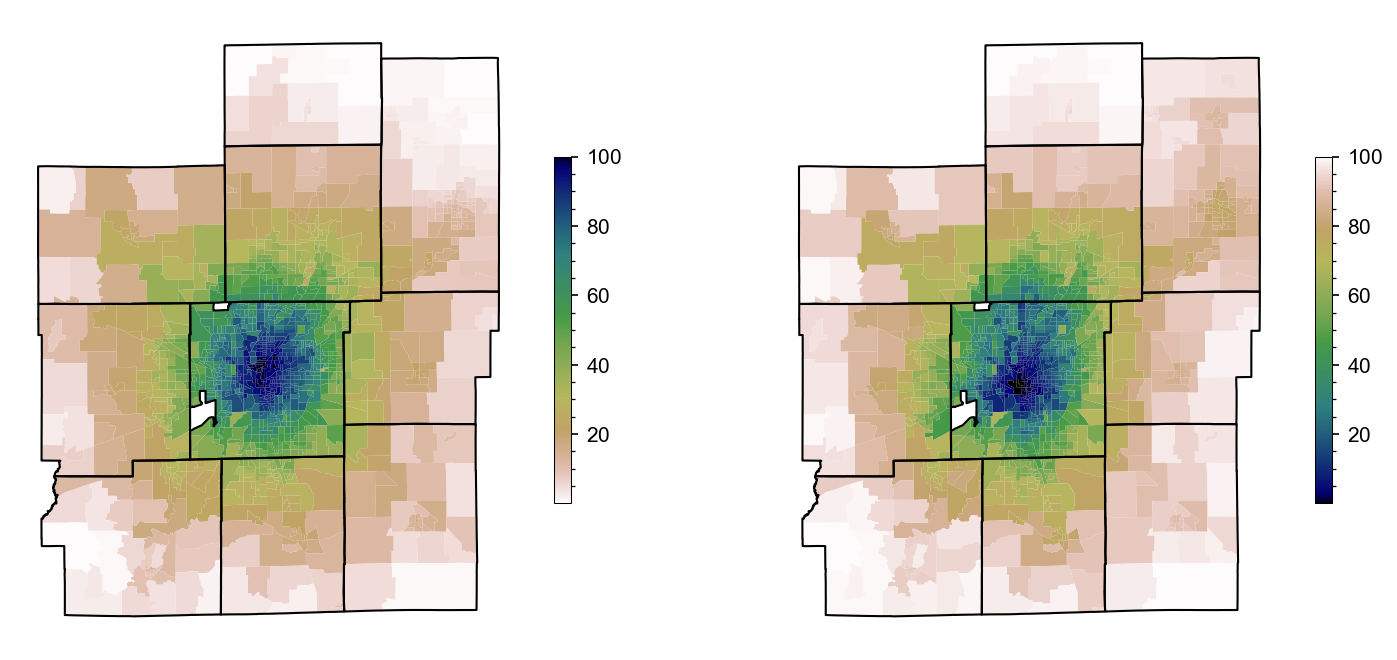

In [ ]:
fig_access_comparison('Drive', 'Work', pctile=1)

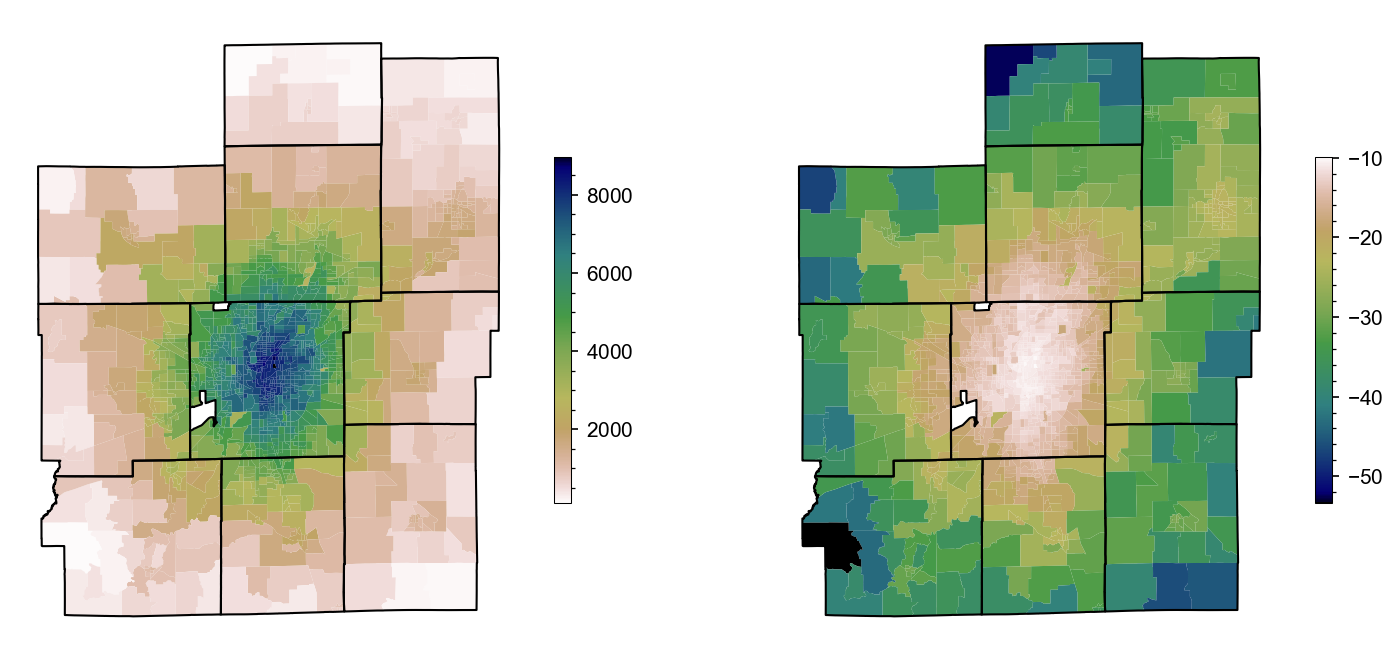

In [69]:
fig_access_comparison(mode='Drive', purpose='Non-work')

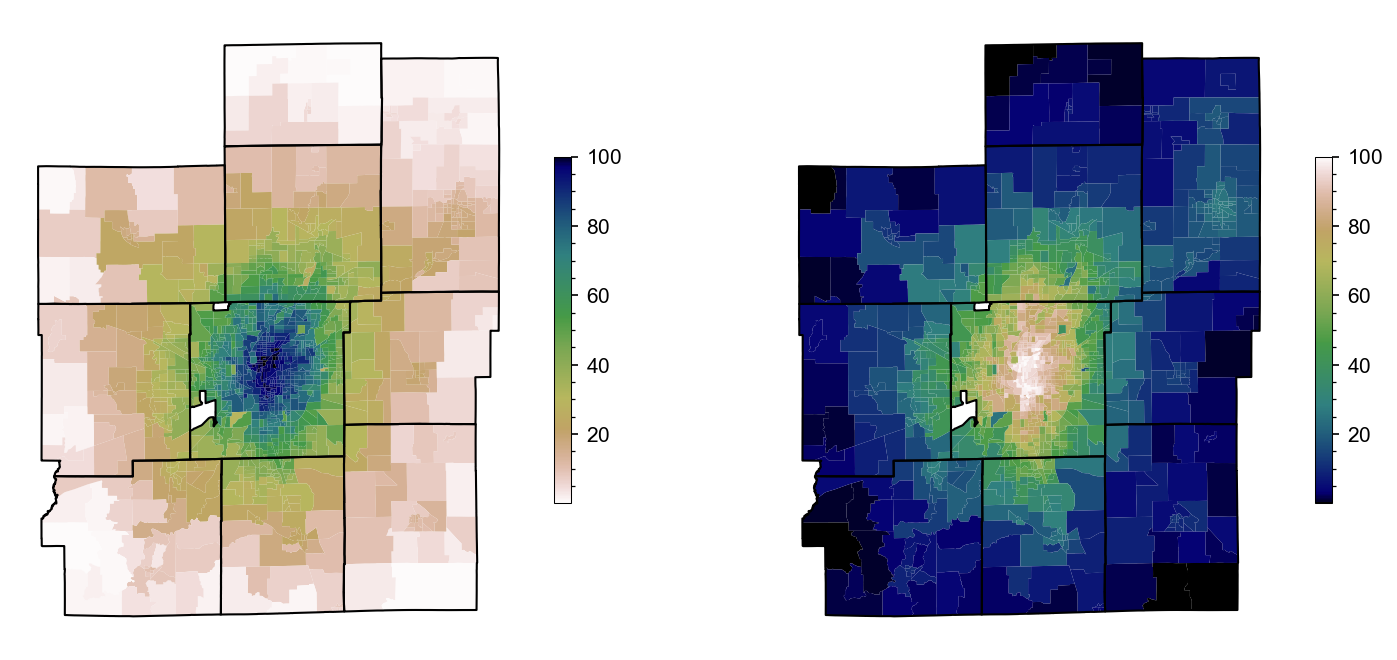

In [70]:
fig_access_comparison(mode='Drive', purpose='Non-work', pctile=1)

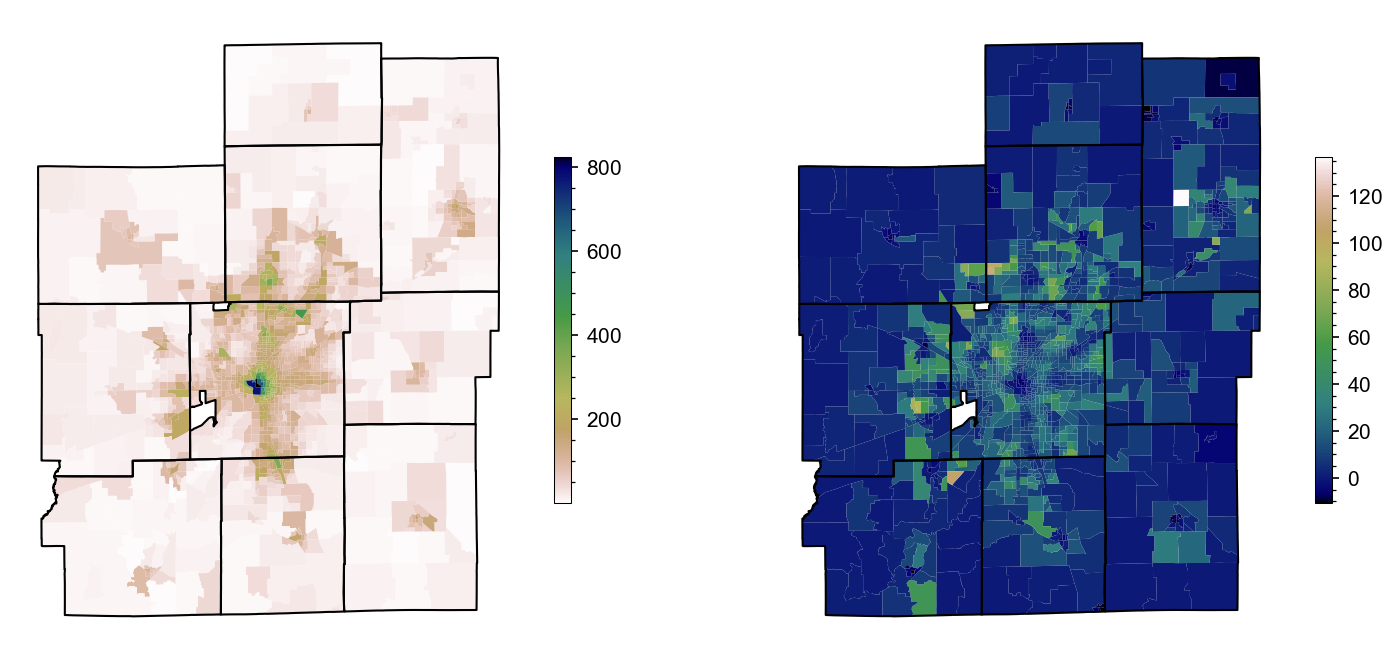

In [71]:
fig_access_comparison(mode='Walk', purpose='Non-work')

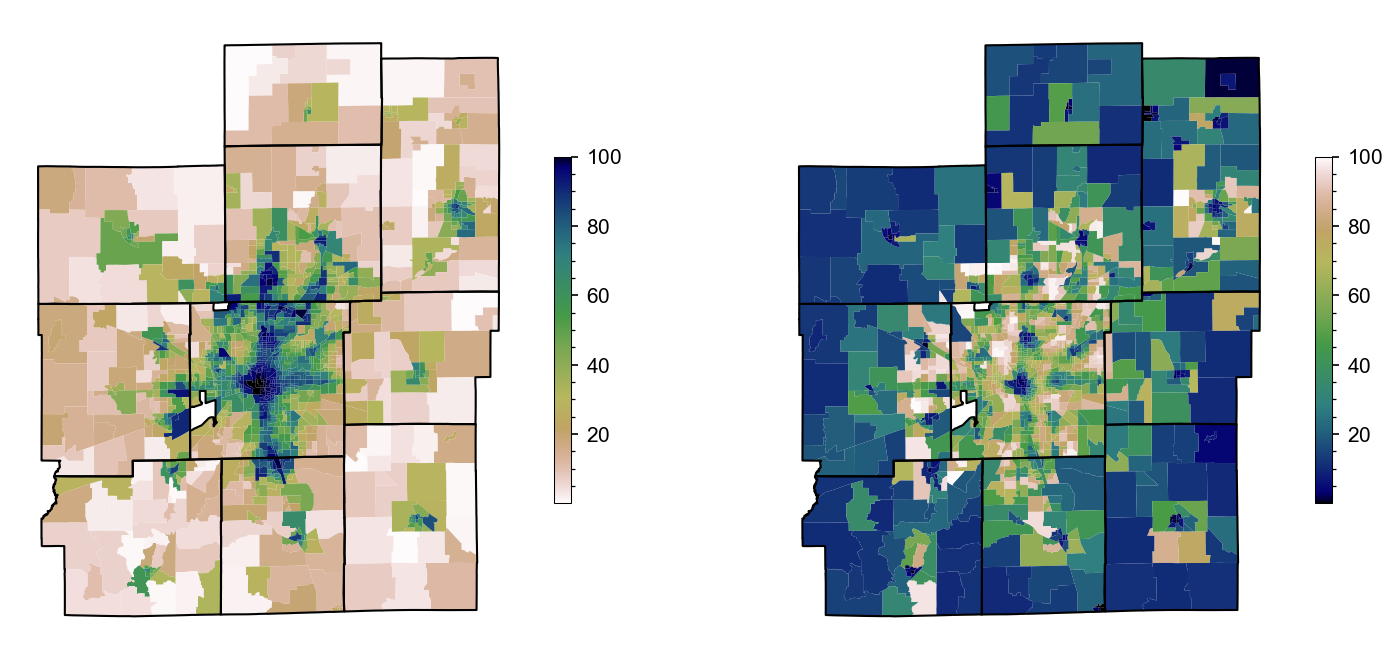

In [74]:
fig_access_comparison(mode='Walk', purpose='Non-work', pctile=1)

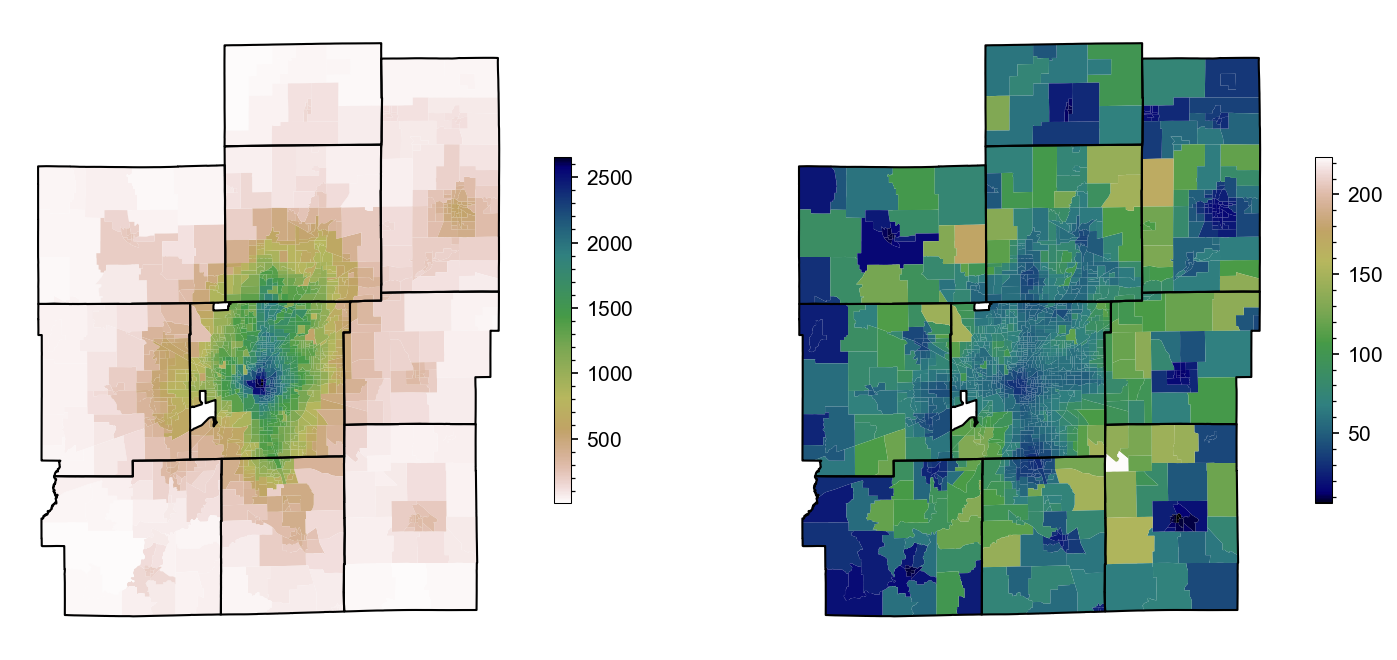

In [72]:
fig_access_comparison(mode='Bike', purpose='Non-work')

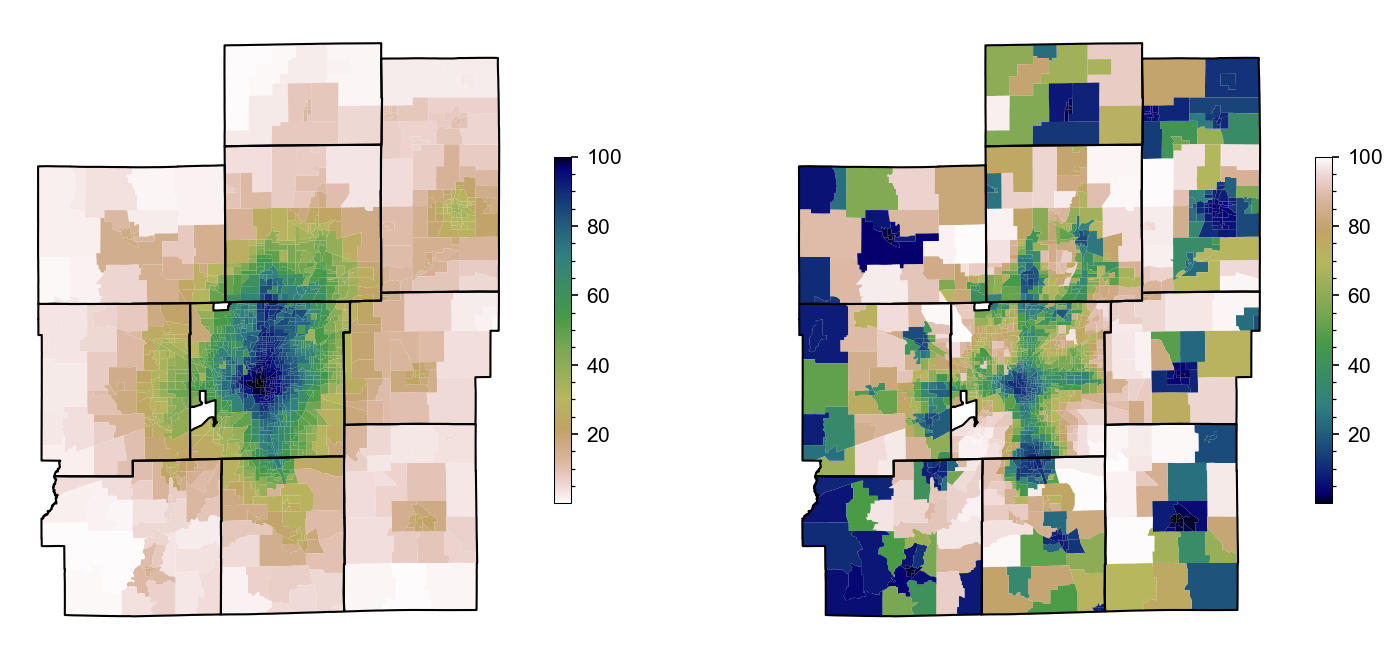

In [73]:
fig_access_comparison(mode='Bike', purpose='Non-work', pctile=1)

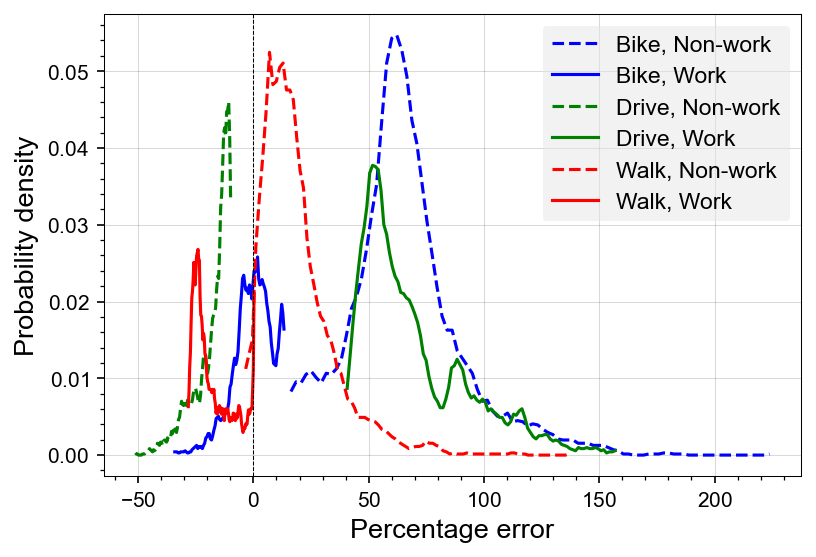

In [21]:
ax = pplot(size=(6, 4), ylab='Probability density', xlab='Percentage error')
for (mode, purp), df in xs_bg.groupby(['mode', 'purpose']):
    y, x = np.histogram(df.pct_diff, 100)
    y = Series((y / y.sum())).rolling(5).mean()
    ax.plot(x[1:], y, label=f'{mode}, {purp}', lw=1.5,
            color=D(Drive='g', Bike='b', Walk='r')[mode],
            ls={'Work': '-', 'Non-work': '--'}[purp])
ax.legend(); ax.axvline(0, color='k', ls='--', lw=0.5);

<Axes: >

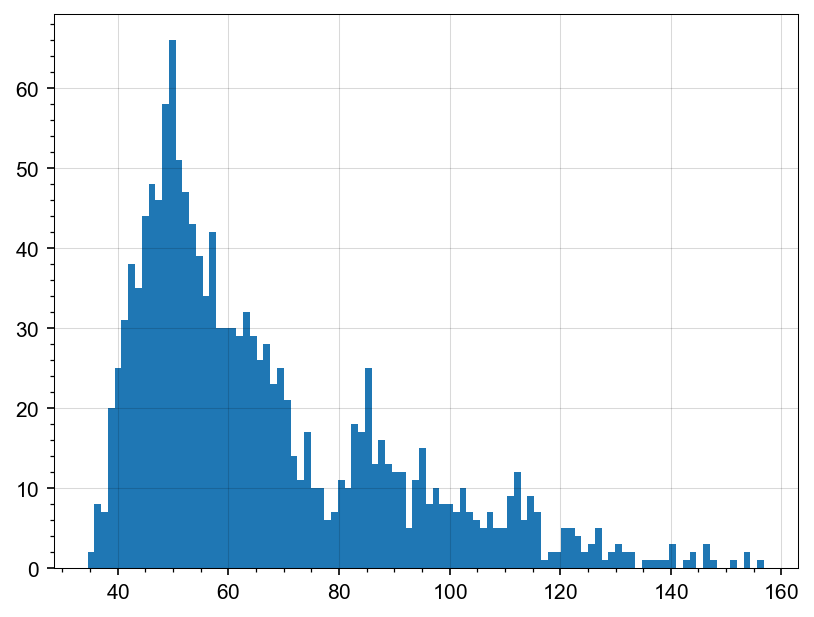

In [11]:
x.pct_diff.hist(bins=100)

  0%|          | 0/3 [00:00<?, ?it/s]

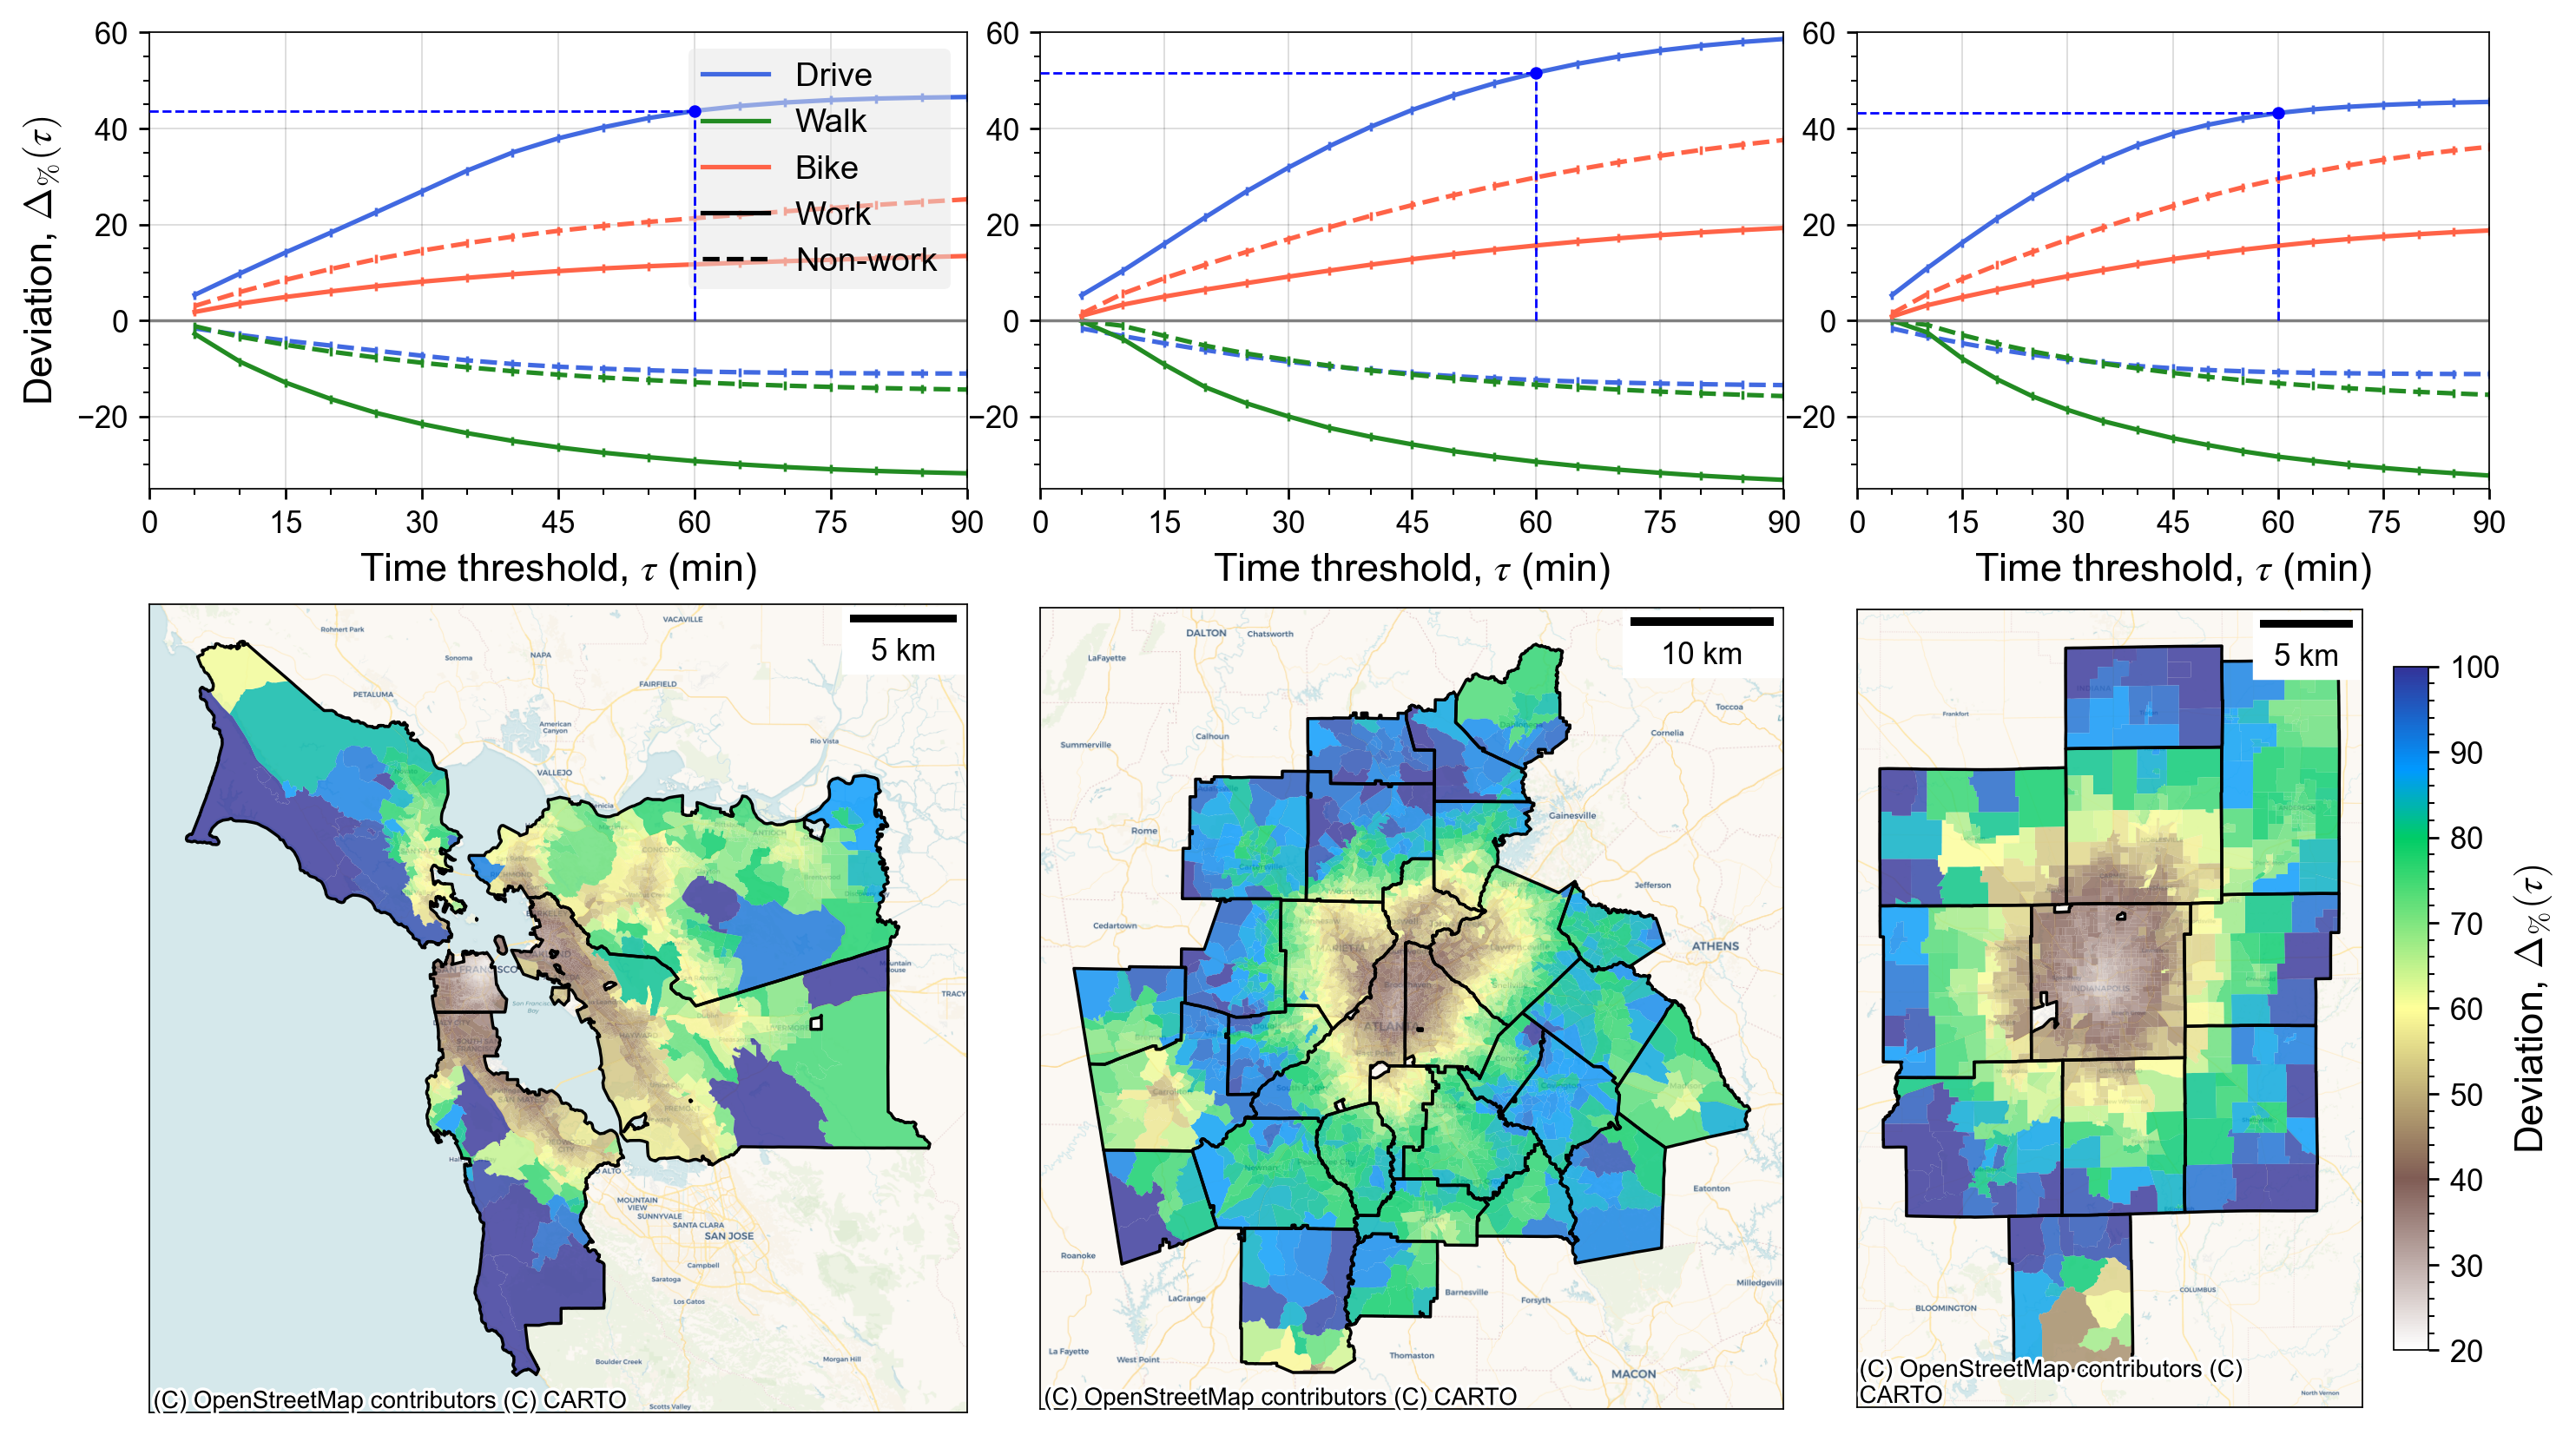

In [12]:
def fig_access_comparison(xs_bg=xs_bg, xs_msa=xs_diff_msa,
                          dpi=150, cmap='terrain_r'):
    _, axes = plt.subplots(2, 3, figsize=(12, 8), dpi=dpi,
                           gridspec_kw=D(width_ratios=[1.1, 1, 0.85],
                                         height_ratios=[2, 6]))
    mode_colors = D(Drive='royalblue', Walk='forestgreen', Bike='tomato')
    purp_ls = {'Work': '-', 'Non-work': '--'}
    xs = xs_bg.query('mode=="Drive" & purpose=="Work" & thresh==60')
    zones = gpd.read_parquet(outroot / 'zones.parquet')
    msas = ('San Francisco', 'Atlanta', 'Indianapolis')
    ylabel = 'Deviation, $\Delta_{\%}(τ)$'
    line = lambda l, **kw: mpl.lines.Line2D([0], [0], label=l, **kw)
    for j, msa in enumerate(tqdm(msas)):
        ## Top row: Percent change by threshold
        ax = pplot(axes[0, j], xlab='Time threshold, $τ$ (min)',
                   xlim=(0, 90), ylim=(-35, 60))
        df = xs_msa.query(f'msa=="{msa}"')
        for mode, color in mode_colors.items():
            df2 = df[df['mode'] == mode]
            for purpose, ls in purp_ls.items():
                d = df2.query(f'purpose=="{purpose}"')
                ax.plot(d.thresh, d.pct_diff, '|' + ls, lw=1.5,
                        markersize=3, color=color)
                if mode == 'Drive' and purpose == 'Work':
                    y = d.set_index('thresh').loc[60].pct_diff
                    ax.scatter(60, y, marker='o', s=10, color='b', zorder=10)
                    ax.plot([0, 60], [y] * 2, 'b--', lw=0.8, zorder=10)
                    ax.plot([60] * 2, [0, y], 'b--', lw=0.8, zorder=10)
        ax.axhline(0, color='grey', lw=1)
        ax.set_xticks(np.arange(0, 91, 15))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
        if j == 0:
            ax.set_ylabel(ylabel)
            ax.legend(loc='upper right', handles=[
                *[line(k, color=v) for k, v in mode_colors.items()],
                *[line(k, color='k', ls=v) for k, v in purp_ls.items()]])
        ## Bottom row: Map
        df = zones[zones.region == msa.replace(' ', '-').lower()]
        df = df[['geoid', 'geometry']].merge(xs)
        cnty = df.assign(geoid=df.geoid.str[:5])[
            ['geoid', 'geometry']].dissolve('geoid')
        ax = pplot(axes[1, j])
        df.plot(ax=ax, column='pct_diff', cmap=cmap, vmin=20, vmax=100, alpha=0.8,
                legend=j == 2, legend_kwds=D(shrink=0.5, label=ylabel))
        cnty.plot(ax=ax, ec='k', lw=1, fc='none')
        ctx.add_basemap(ax=ax, crs=CRS_M, source=ctx.providers.CartoDB.Voyager)
        ax.add_artist(ScaleBar(0.2))
        ax.tick_params(axis='both', which='both', left=0, bottom=0)
        ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=-0.18)

x = fig_access_comparison(dpi=250); x # t=0:15

## 2.3. Opportunities map

In [19]:
zones = gpd.read_parquet(outroot / 'zones.parquet').set_crs(CRS_M).disp()

8,514 rows x 4 cols; Memory: 1.2 MiB; CRS: EPSG:3857


region         geoid  \
        <object>      <object>   
0  san-francisco  060014001001   

                                            geometry       popu  
                                          <geometry>  <float64>  
0  POLYGON ((-13608463.772251 4563242.954634, -13...     1963.0

In [20]:
(zones.assign(area=zones.area * SQM2SQMI)
 .groupby('region')[['area','popu']].sum()
 .assign(pop_density=lambda df: df.popu / df['area']))

area       popu  pop_density
region                                             
atlanta        12896.615600  6035460.0   467.987896
indianapolis    6964.238822  2067684.0   296.900214
san-francisco   4136.520603  4672587.0  1129.593552